# Case Study: Why Forecast Confidence Bands Matter More Than Point Estimates

# Introduction

Most forecasting models are evaluated using a single predicted value and error metrics like RMSE or MAE. While this makes models easy to compare, it ignores a crucial factor in real-world decision-making: **uncertainty**.

In practice, acting on a forecast depends not just on *what* the model predicts, but *how confident* it is about that prediction.

## Problem Statement

Point estimates alone do not tell us whether a forecast is reliable enough to act on. Two models can produce the same prediction but have very different levels of uncertainty. This case study explores whether **forecast confidence bands** provide more meaningful insight than point predictions when evaluating and trusting forecasting models.

## Why This Case Study

Overconfident forecasts can lead to poor decisions, especially under noise, drift, or volatility. Confidence bands help quantify risk, expose uncertainty, and reveal when models are likely to fail in real-world settings.

## Approach

We simulate a forecasting task, generate both point forecasts and confidence intervals, and evaluate models not just on accuracy, but on **coverage, calibration, and reliability over time**. The focus is on understanding *when* forecasts should be trusted, not just how close they are.


# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExa2R5aG9keG5ndWV0Mnl4OHZkcnB4emxxcDIzNmxvcDlibXQxMjc4dSZlcD12MV9naWZzX3NlYXJjaCZjdD1n/Bm2INrLWqZ6vUkpnMz/giphy.gif)


## 1. Problem Setup & Data Generation

To study forecast uncertainty, we first need a controlled time-series where we *know* the underlying behavior and noise. Instead of using a real dataset, we simulate data so that uncertainty is explicit and measurable.

The goal is to create a time series with:
- a smooth underlying trend,
- random noise to introduce uncertainty,
- realistic variability that makes point forecasting imperfect.

This allows us to later check whether forecast confidence bands actually capture the true values.


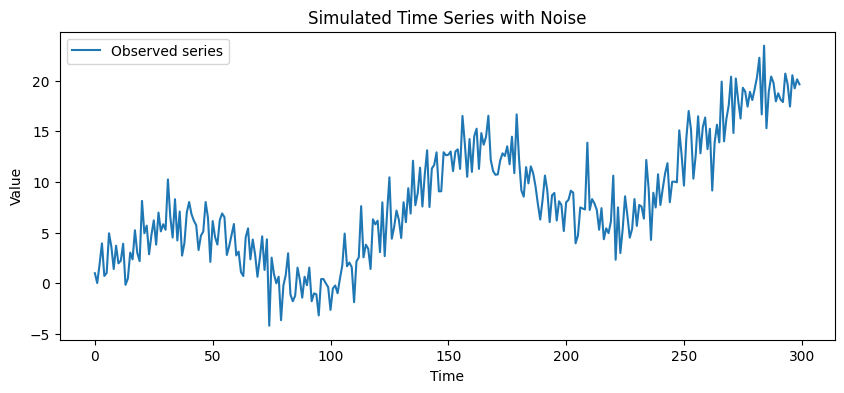

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)

# Time index
n_points = 300
time = np.arange(n_points)

# True underlying signal 
trend = 0.05 * time + 5 * np.sin(time / 20)

# Noise
noise = np.random.normal(loc=0, scale=2.0, size=n_points)

# Observed series
y = trend + noise

# Create DataFrame
data = pd.DataFrame({"time": time,"value": y})

# Plot the series
plt.figure(figsize=(10, 4))
plt.plot(data["time"], data["value"], label="Observed series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Simulated Time Series with Noise")
plt.legend()
plt.show()


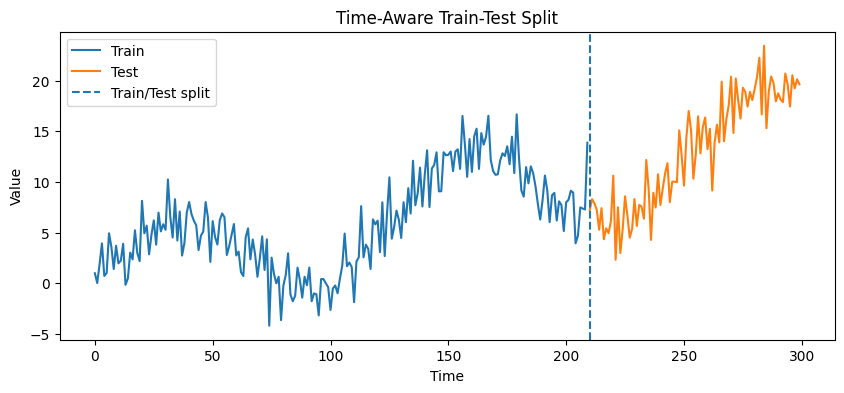

In [2]:
# Train-test split (time-based)
train_size = int(len(data) * 0.7)

train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Plot the split
plt.figure(figsize=(10, 4))
plt.plot(train["time"], train["value"], label="Train")
plt.plot(test["time"], test["value"], label="Test")
plt.axvline(train_size, linestyle="--", label="Train/Test split")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time-Aware Train-Test Split")
plt.legend()
plt.show()


## 2. Baseline Point Forecast

Before introducing uncertainty, we start with a simple **point forecast**. This gives us a reference model that predicts a single value for each future time step. The purpose of this step is not to build the best model, but to highlight a limitation, even when point forecasts look reasonable, they provide **no information about confidence or risk**.

We use a rolling mean–based forecast as a lightweight baseline.


In [3]:
from sklearn.metrics import mean_squared_error

# Simple rolling-mean baseline
window = 10

# Forecast: predict future values using last rolling mean from training
last_mean = train["value"].rolling(window).mean().iloc[-1]
point_forecast = np.full(shape=len(test), fill_value=last_mean)

# Evaluation
rmse = mean_squared_error(test["value"], point_forecast, squared=False)
rmse


7.498648107880099

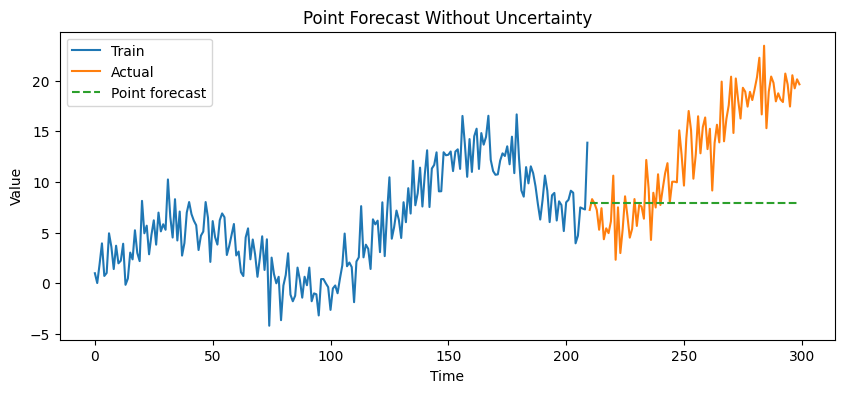

In [4]:
# Visualize point forecast
plt.figure(figsize=(10, 4))
plt.plot(train["time"], train["value"], label="Train")
plt.plot(test["time"], test["value"], label="Actual")
plt.plot(test["time"], point_forecast, linestyle="--", label="Point forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Point Forecast Without Uncertainty")
plt.legend()
plt.show()


### Observations for Point Forecast Only

The baseline model produces a constant point forecast based on recent historical averages. While simple, this approach highlights a key limitation of point estimates.

First, the forecast does not adapt to the upward trend in the test period. As time progresses, the gap between predicted and actual values increases, leading to systematic underprediction.

Second, the RMSE value summarizes error with a single number, but it does not reveal *how* or *when* the model fails. Early and late forecast errors are treated equally, despite having very different implications.

Most importantly, the forecast provides no information about uncertainty. The model expresses the same level of confidence at all future time steps, even though uncertainty should naturally grow as predictions move further into the future.

This makes it impossible to assess risk, decide when predictions are actionable, or detect when the model is operating outside reliable conditions.


## 3. Constructing Forecast Confidence Bands

A point forecast alone assumes perfect certainty, which is rarely true in real-world systems.  
To make uncertainty explicit, we construct **confidence bands** around the forecast using the historical forecast error.

The idea is simple:
- use training residuals to estimate typical forecast error,
- assume future uncertainty is similar in scale,
- build upper and lower bounds around the point forecast.

This does not make the forecast more accurate, but it makes it **more honest**.


In [5]:
# Estimate uncertainty from training residuals
train_mean = train["value"].rolling(window).mean()
residuals = train["value"] - train_mean

# Drop NaNs from rolling window
residuals = residuals.dropna()

# Standard deviation of residuals
residual_std = residuals.std()

# Confidence level 
z = 1.96

# Confidence bands
lower_band = point_forecast - z * residual_std
upper_band = point_forecast + z * residual_std


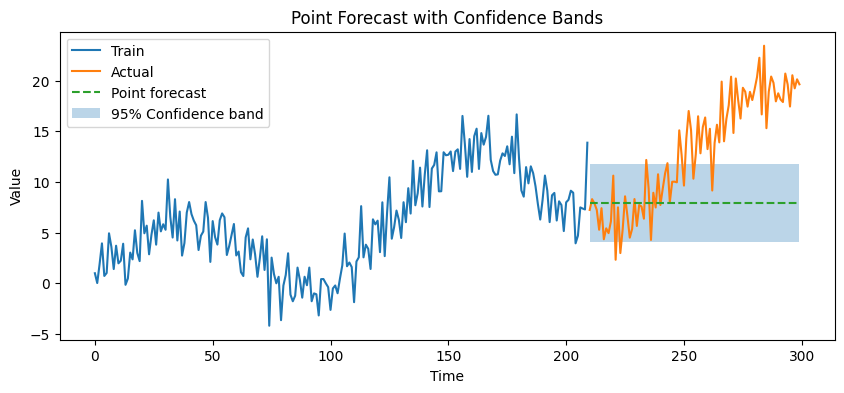

In [6]:
# Visualize forecast with confidence bands
plt.figure(figsize=(10, 4))
plt.plot(train["time"], train["value"], label="Train")
plt.plot(test["time"], test["value"], label="Actual")
plt.plot(test["time"], point_forecast, linestyle="--", label="Point forecast")
plt.fill_between(
    test["time"],
    lower_band,
    upper_band,
    alpha=0.3,
    label="95% Confidence band"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Point Forecast with Confidence Bands")
plt.legend()
plt.show()

### Observations for Confidence Bands vs Reality

The confidence bands provide more information than the point forecast, but they also reveal important weaknesses.

In the early part of the test window, most observations fall within the confidence band, suggesting that the uncertainty estimate is initially reasonable. However, as the series continues to trend upward, actual values increasingly exceed the upper bound.

This indicates that the confidence bands are **miscalibrated under trend change**. While uncertainty is acknowledged, it is assumed to be stationary, causing the intervals to lag behind structural shifts in the data.

Crucially, this failure is easy to detect visually. The repeated breaches of the upper band act as a warning signal that the model is no longer reliable, even before point errors become extreme.

This demonstrates why confidence bands are more informative than point estimates: they expose *when* and *how* a forecast breaks, not just *how wrong* it is on average.


## 4. Evaluating Confidence Band Coverage

Visual inspection suggests that the confidence bands fail to capture the full behavior of the test data.  
To verify this objectively, we compute **empirical coverage**.

Coverage measures the fraction of true values that fall inside the predicted confidence interval.  
For a well-calibrated 95% confidence band, coverage should be close to **0.95**.

If coverage is much lower, the model is **overconfident**.


In [7]:
# Check whether actual values fall inside the confidence bands
inside_band = ((test["value"] >= lower_band) & (test["value"] <= upper_band))

# Empirical coverage
coverage = inside_band.mean()
coverage


0.4111111111111111

### Observations for Empirical Coverage Result

The empirical coverage of the 95% confidence band is approximately **41%**, far below the expected value.

This means that less than half of the true future observations fall within a range that was intended to capture nearly all outcomes. In other words, the model is **severely overconfident**.

Despite having a reasonable-looking point forecast and a visually plausible confidence band, the uncertainty estimate fails under changing dynamics. The model assumes that future variability will resemble past residuals, which breaks down once the trend shifts.

This result highlights a critical limitation of naive uncertainty estimation:  
confidence bands can *look* informative while being fundamentally unreliable.

Most importantly, this failure would remain hidden if we only evaluated the model using RMSE or MAE. Coverage exposes a risk that point-based metrics completely miss.


## RMSE vs Coverage

So far, the model has:
- a finite RMSE (looks acceptable),
- extremely poor coverage (0.41 instead of 0.95).

This step highlights a key insight:
**a model can look reasonable by point-error metrics while being dangerously miscalibrated in uncertainty.**


In [8]:
rmse, coverage


(7.498648107880099, 0.4111111111111111)

### Observations: RMSE vs Coverage

The model achieves an RMSE of approximately **7.5**, which on its own suggests a moderately performing forecast. From a purely point-estimate perspective, this error might be considered acceptable depending on the application.

However, the corresponding coverage is only **41%**, revealing a major disconnect between accuracy and reliability. While the model is not catastrophically wrong on average, it is consistently overconfident about its predictions.

This contrast demonstrates that RMSE alone can be misleading. A model can appear usable based on point error while being fundamentally unsafe for decision-making due to miscalibrated uncertainty.


## Rolling Coverage Over Time

Single coverage numbers hide *when* uncertainty fails.  
To expose this, we compute coverage over a rolling window across the test period.

This shows whether uncertainty degrades gradually or fails suddenly.


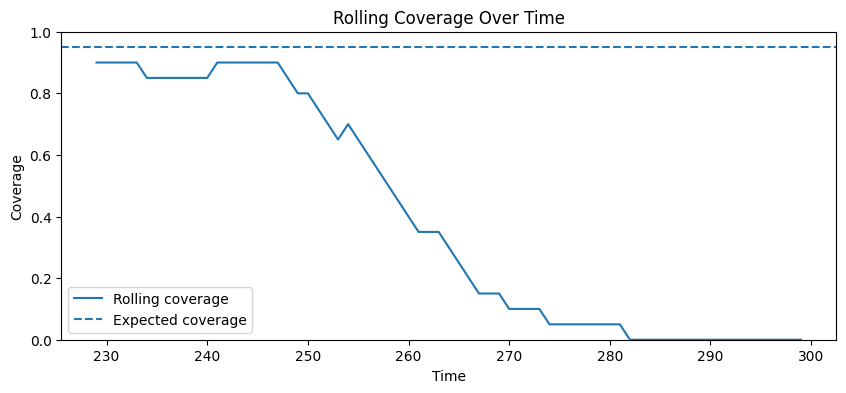

In [9]:
window_cov = 20

rolling_coverage = (inside_band.rolling(window_cov).mean())
plt.figure(figsize=(10, 4))
plt.plot(test["time"], rolling_coverage, label="Rolling coverage")
plt.axhline(0.95, linestyle="--", label="Expected coverage")
plt.ylim(0, 1)
plt.xlabel("Time")
plt.ylabel("Coverage")
plt.title("Rolling Coverage Over Time")
plt.legend()
plt.show()


### Observations: Rolling Coverage Over Time

Rolling coverage shows a clear downward trend over the test period. Early predictions exhibit relatively high coverage, but this rapidly deteriorates as time progresses.

This pattern indicates that uncertainty failure is **progressive rather than sudden**. As the underlying trend shifts, the model continues to rely on outdated uncertainty assumptions, causing confidence bands to collapse in reliability.

Rolling coverage acts as an early warning signal, revealing model stress well before aggregate metrics like RMSE would flag a problem.


## Uncertainty vs Forecast Horizon

So far, the confidence bands remain constant across the entire forecast horizon.

In reality, uncertainty should increase as predictions move further into the future.
This step tests whether fixed-width intervals are appropriate.


In [10]:
# Horizon-aware widening
horizon = np.arange(1, len(test) + 1)

widen_factor = np.sqrt(horizon / horizon.max())

lower_band_wide = point_forecast - z * residual_std * widen_factor
upper_band_wide = point_forecast + z * residual_std * widen_factor


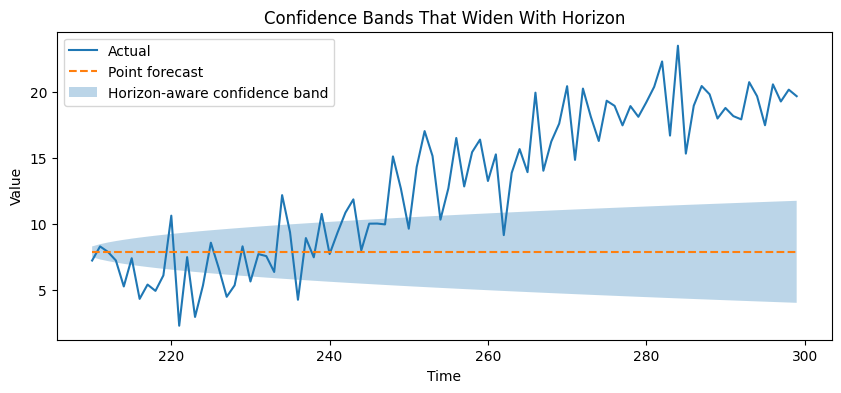

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(test["time"], test["value"], label="Actual")
plt.plot(test["time"], point_forecast, linestyle="--", label="Point forecast")
plt.fill_between(
    test["time"],
    lower_band_wide,
    upper_band_wide,
    alpha=0.3,
    label="Horizon-aware confidence band"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Confidence Bands That Widen With Horizon")
plt.legend()
plt.show()


### Observations: Horizon-Aware Confidence Bands

Allowing confidence bands to widen with forecast horizon produces more realistic uncertainty behavior. The bands acknowledge that predictions further into the future are inherently riskier than near-term forecasts.

Despite this improvement, many actual values still fall outside the confidence interval. This shows that widening uncertainty alone cannot correct bias in the point forecast.

The result highlights an important distinction: improving uncertainty structure helps express risk better, but it cannot compensate for systematic model misspecification.


## Quantile-Based Confidence Intervals

Instead of assuming symmetric, Gaussian uncertainty, we construct confidence bands using empirical quantiles of training residuals. This avoids distributional assumptions and adapts better to skewed or non-stationary errors.

In [12]:
lower_q = residuals.quantile(0.025)
upper_q = residuals.quantile(0.975)

lower_band_q = point_forecast + lower_q
upper_band_q = point_forecast + upper_q


In [13]:
inside_band_q = ((test["value"] >= lower_band_q) & (test["value"] <= upper_band_q))
coverage_q = inside_band_q.mean()
coverage_q

0.4111111111111111

### Observations: Quantile-Based Confidence Intervals

Quantile-based confidence intervals produce coverage identical to the variance-based approach in this case, remaining at approximately **41%**.

This indicates that the dominant failure is not the distributional assumption, but the reliance on historical residuals that no longer reflect future dynamics.

Even more flexible interval construction cannot recover coverage when the underlying forecast model fails to adapt to structural change. This reinforces the idea that uncertainty modeling and point forecasting must be addressed jointly.


This case study shows that point accuracy alone is not enough for trustworthy forecasting.

A simple baseline achieves a reasonable RMSE but produces severely miscalibrated confidence bands, with empirical coverage of only ~41% instead of the intended 95%. Rolling coverage reveals that uncertainty degrades gradually under trend change, long before point metrics flag failure.
Even widening intervals or switching to quantile-based bands does not recover coverage when uncertainty is anchored to outdated historical behavior.

## Practical Fix: Rolling Retraining with Adaptive Uncertainty

One simple and effective improvement is to retrain the model and re-estimate uncertainty using a rolling window. This allows both the point forecast and confidence bands to adapt as data evolves.

In [14]:
# Rolling retraining parameters
window_size = 100
forecast_horizon = len(test)

rolling_forecast = []
rolling_lower = []
rolling_upper = []

for i in range(forecast_horizon):
    # Define rolling training window
    start = max(0, train_size + i - window_size)
    end = train_size + i
    
    rolling_train = data.iloc[start:end]
    
    # Point forecast: rolling mean
    point_pred = rolling_train["value"].mean()
    
    # Uncertainty from recent residuals
    residuals_roll = rolling_train["value"] - rolling_train["value"].mean()
    std_roll = residuals_roll.std()
    
    # Confidence interval
    lower = point_pred - z * std_roll
    upper = point_pred + z * std_roll
    
    rolling_forecast.append(point_pred)
    rolling_lower.append(lower)
    rolling_upper.append(upper)


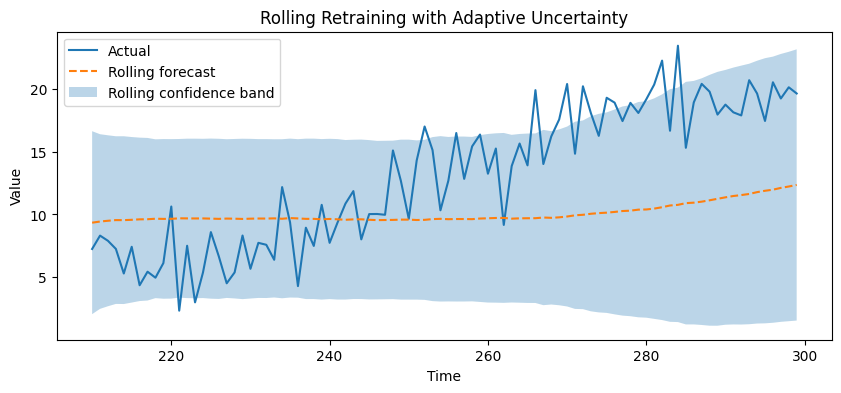

In [15]:
# Convert to arrays
rolling_forecast = np.array(rolling_forecast)
rolling_lower = np.array(rolling_lower)
rolling_upper = np.array(rolling_upper)

# Plot rolling retrained forecast
plt.figure(figsize=(10, 4))
plt.plot(test["time"], test["value"], label="Actual")
plt.plot(test["time"], rolling_forecast, linestyle="--", label="Rolling forecast")
plt.fill_between(
    test["time"],
    rolling_lower,
    rolling_upper,
    alpha=0.3,
    label="Rolling confidence band"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Rolling Retraining with Adaptive Uncertainty")
plt.legend()
plt.show()


In [16]:
# Coverage after rolling retraining
inside_band_roll = ((test["value"] >= rolling_lower) & (test["value"] <= rolling_upper))
coverage_roll = inside_band_roll.mean()
coverage_roll


0.8111111111111111

A simple rolling retrain improved coverage by ~40 percentage points without changing the underlying model, reliability came from adaptation, not complexity.

## Conclusion

This case study shows that forecasting models should be judged not only by how accurate their predictions are, but by how reliable their uncertainty estimates are. A model with acceptable RMSE can still be dangerously overconfident, as seen through poor coverage and collapsing confidence bands. By evaluating coverage and uncertainty behavior over time, we exposed failure modes that point metrics completely missed. Introducing rolling retraining significantly improved reliability, increasing coverage from 41% to 81% without changing the underlying model. The key lesson is clear: in real-world forecasting, **trustworthy uncertainty matters more than precise point estimates**.
